In [384]:
# I started with Robert and Calvin's code. Made some edits to try out my preprocessing ideas.

In [385]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os

In [386]:
def load_song(filename):
    '''Load the sample audio file as a floating point time series.'''
    assert isinstance(filename, str)
    filename = 'Small_audio_sample/' + filename
    chirp_song, sr = librosa.load(filename) # chirp_song is the audio time series, sr is the sampling rate.
    return chirp_song, sr

def trim_freq(D, chop = 0.1):
    '''Takes a dB Mel spectrogram D, and trims off the chop-proportion of the lower frequencies; chop = 0.12 chops up until ~1.3kHz.
    Note: This modifies the np array D in place, so make a copy if you need the original.'''
    D[:int(chop*D.shape[0])] = np.ones((int(chop*D.shape[0]), D.shape[1])) * np.min(D)
    return D
    
def chop_stft(chirp_song, n_fft=2048, hop_length=128):
    '''Computes a short-time Fourier transform (stft) column matrix of everything after the first silence.
    chirp_song = time series of song
    sr = sample rate
    n_fft = FFT parameter'''

    split=librosa.effects.split(chirp_song, top_db=60)
    chirp_song_split=chirp_song[split[1,0]:
                                    #split[1,1]
                                    ]
    
    #Visualize the waveform as a function of time
    #librosa.display.waveshow(chirp_song, sr=sr);
    
    return librosa.stft(chirp_song_split, n_fft=n_fft,  hop_length=hop_length)

In [389]:
# # Example
# filename = '119884.wav'

# chirp_song, sr = load_song(filename)

# chop_stft(chirp_song)

In [390]:
def Melspec(filename, n_fft = 2048, hop_length=128, chop_vertical=0.1):
    '''The Mel spectrogram of everything after the first silence, with bottom chop_vertical proportion of frequencies bottomed out.'''
    #Divide the file into small segments and apply the stft to each. Then along each vertical segment, plot the volume (dB) at each corresponding pitch (Hz) 
    chirp_song, sr = load_song(filename)

    D = np.abs(chop_stft(chirp_song, 
                            n_fft=n_fft,
                            hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)

    trim_freq(DB, chop = chop_vertical)

    librosa.display.specshow(DB, sr=sr, hop_length=1, x_axis='time', y_axis='log');
    plt.colorbar(format='%+2.0f dB');
    plt.ylim(1024, 1024*8)
    plt.show()



In [391]:
def clean_Melspec_Robert(filename, plot=True):
    chirp_song, sr = load_song(filename)

    #Robert: This code comes directly from https://librosa.org/librosa_gallery/auto_examples/plot_vocal_separation.html
    S_full, phase = librosa.magphase(chop_stft(chirp_song, n_fft=2048, hop_length=128))


    # We'll compare frames using cosine similarity, and aggregate similar frames
    # by taking their (per-frequency) median value.
    #
    # To avoid being biased by local continuity, we constrain similar frames to be
    # separated by at least 2 (Robert: 2 won't run on the small audio samples) seconds.
    #
    # This suppresses sparse/non-repetetitive deviations from the average spectrum,
    # and works well to discard vocal elements.

    S_filter = librosa.decompose.nn_filter(S_full,
                                        aggregate=np.median,
                                        metric='cosine',
                                        width=int(librosa.time_to_frames(.2, sr=sr)))

    # The output of the filter shouldn't be greater than the input
    # if we assume signals are additive.  Taking the pointwise minimium
    # with the input spectrum forces this.
    S_filter = np.minimum(S_full, S_filter)


    # We can also use a margin to reduce bleed between the vocals and instrumentation masks.
    # Note: the margins need not be equal for foreground and background separation
    margin_i, margin_v = 5, 6
    power = 2

    mask_i = librosa.util.softmask(S_filter,
                                margin_i * (S_full - S_filter),
                                power=power)

    mask_v = librosa.util.softmask(S_full - S_filter,
                                margin_v * S_filter,
                                power=power)

    # Once we have the masks, simply multiply them with the input spectrum
    # to separate the components

    S_foreground = mask_v * S_full
    S_background = mask_i * S_full


    # Converting to dB, and chopping off low frequencies

    DB_full = librosa.amplitude_to_db(S_full, ref=np.max)
    DB_background = librosa.amplitude_to_db(S_background, ref=np.max)
    DB_foreground = librosa.amplitude_to_db(S_foreground, ref=np.max)

    trim_freq(DB_full)
    trim_freq(DB_background)
    trim_freq(DB_foreground)

    if plot:
        # sphinx_gallery_thumbnail_number = 2

        plt.figure(figsize=(12, 12))
        
        plt.subplot(3, 1, 1)
        plt.ylim(1024, 1024*8)
        librosa.display.specshow(DB_full,
                                y_axis='log', sr=sr)
        plt.title('Full spectrum')
        plt.colorbar()

        plt.subplot(3, 1, 2)
        plt.ylim(1024, 1024*8)
        librosa.display.specshow(DB_background,
                                y_axis='log', sr=sr)
        plt.title('Background')
        plt.colorbar()

        plt.subplot(3, 1, 3)
        plt.ylim(1024, 1024*8)
        librosa.display.specshow(DB_foreground,
                                y_axis='log', x_axis='time', sr=sr)
        

        plt.title('Foreground')
        plt.colorbar()

        plt.tight_layout()
        plt.show()
    
    return DB_foreground

In [392]:
def clean_Melspec_Calvin(filename, plot=True, n_fft = 2048, hop_length=128, chop_vertical=0.1):
    chirp_song, sr = load_song(filename)
    D = np.abs(chop_stft(chirp_song, n_fft=n_fft, hop_length=hop_length))
    DB = librosa.amplitude_to_db(D, ref=np.max)

    trim_freq(DB, chop = chop_vertical)

    DBclean = np.zeros(D.shape)
    for x in range(0,DB.shape[0]):
        med = np.median(DB[x, :])
        DBclean[x, :] = DB[x, :]-med

    if plot:
        plt.figure(figsize=(12,6))
        librosa.display.specshow(DBclean, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
        plt.colorbar(format='%+2.0f dB');
        plt.ylim(1024, 1024*8)
        plt.title(str(filename))
        plt.show()
    
    return DBclean

In [393]:
# directory = 'Small_audio_sample'
# hop_length = 1024
# n_fft = 2048

# for filename in os.listdir(directory):
#     f = os.path.join(directory, filename)
#     # checking if it is a file
#     if os.path.isfile(f):
#         clean_Melspec_Calvin(filename)

# Harma procedure

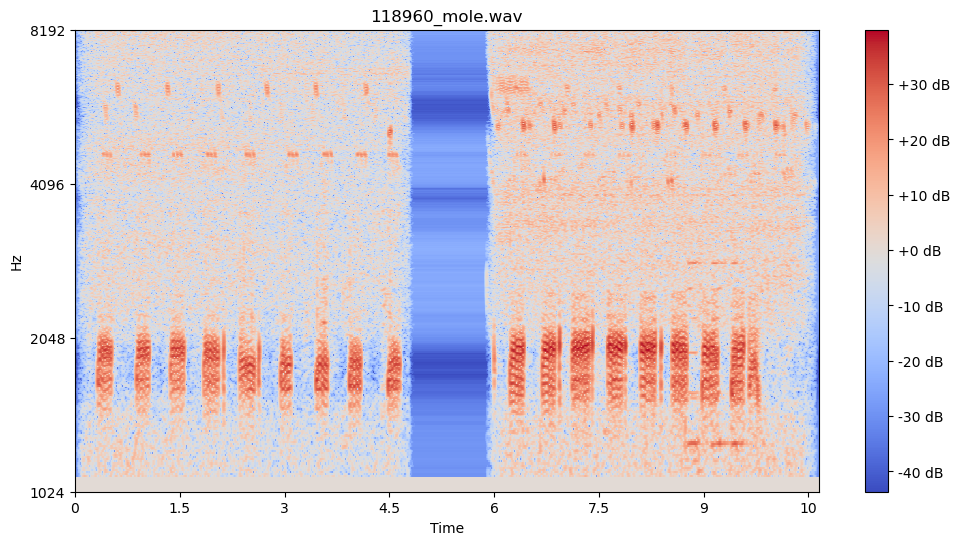

In [394]:
filename = '118960_mole.wav'
DB = clean_Melspec_Calvin(filename)

In [395]:
chirp_song, sr = load_song(filename)

In [396]:
D = np.abs(chop_stft(chirp_song, n_fft=2048, hop_length=64))
trim_freq(D, chop = 0.1)

Dclean = np.zeros(D.shape)
for x in range(0,D.shape[0]):
    med = np.median(D[x, :])
    Dclean[x, :] = [0 if D[x,y] < .5*med else D[x,y] for y in range(D.shape[1])]

DB = librosa.amplitude_to_db(D, ref=np.max)
DBclean = np.zeros(D.shape)
for x in range(0,DB.shape[0]):
    med = np.median(DB[x, :])
    DBclean[x, :] = DB[x, :]-med
    #DBclean[x, :] = [0 if D[x,y] < med else D[x,y] for y in range(D.shape[1])]

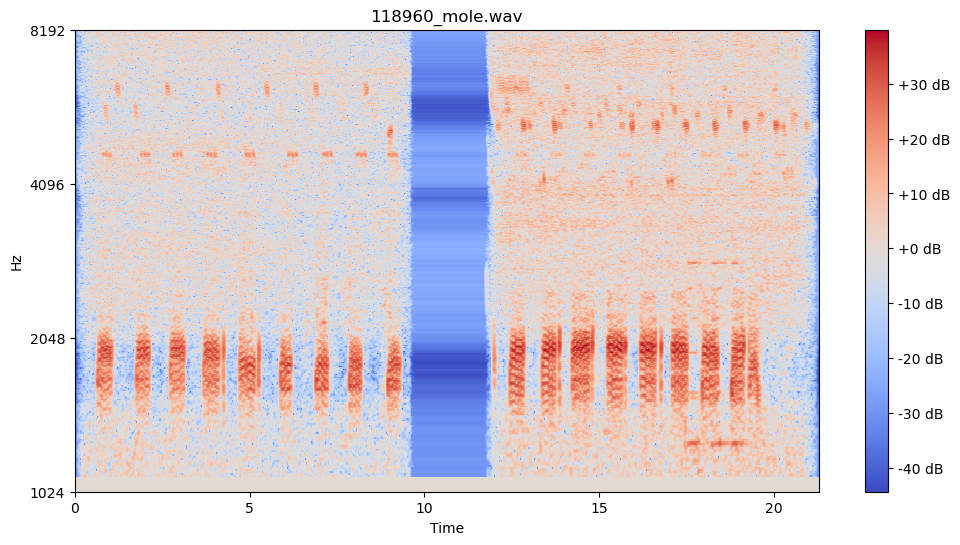

In [397]:
plt.figure(figsize=(12,6))
librosa.display.specshow(DBclean, sr=sr, hop_length=128, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.ylim(1024, 1024*8)
plt.title(str(filename))
plt.show()

In [398]:
max_amp = np.max(D)
max_freq, max_t = np.unravel_index(np.argmax(D), D.shape)

search_width = 1

freq_plot = [max_freq]
amp_plot = [D[max_freq, max_t]]

threshold_amp = (np.max(D) - np.min(D)) * .7
threshold_dB = 20*np.log10(threshold_amp)

# going left
def best_left(D,i,j):
    '''Returns where next we should go in frequency.'''    
    return np.argmax(D[i - search_width: i + search_width + 1 , j-1])

i = max_freq
j = max_t
count = 0
while D[i-search_width+best_left(D,i,j) , j-1] >= (max_amp - threshold_amp) and count < 1000 and i in range(D.shape[0]):
    i_new = i-search_width+best_left(D,i,j) 
    freq_plot = [i_new] + freq_plot
    amp_plot = [D[i_new, j-1]] + amp_plot
    i = i_new 
    j = j-1
    count += 1
total_left_steps = count

# going right
def best_right(D,i,j):
    '''Returns where next we should go in frequency.'''    
    return np.argmax(D[i-search_width : i+search_width + 1 , j+1])

i = max_freq
j = max_t
count = 0
while D[i-search_width+best_right(D,i,j) , j+1] >= (max_amp - threshold_amp) and count < 1000 and i in range(D.shape[0]):
    i_new = i-search_width+best_right(D,i,j) 
    freq_plot = freq_plot + [i_new]  
    amp_plot = amp_plot + [D[i_new, j-1]]
    i = i_new 
    j = j+1
    count += 1
total_right_steps = count

In [399]:
threshold_dB

36.63223323984509

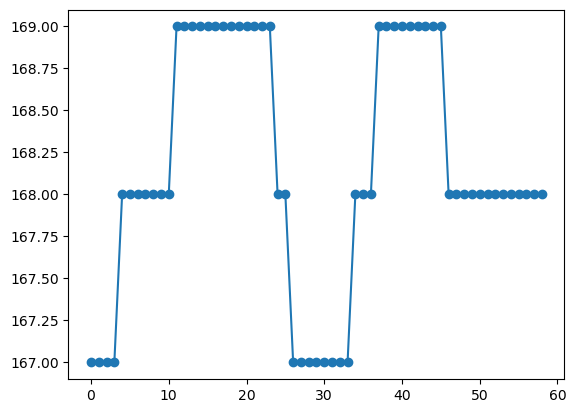

In [400]:
plt.plot(np.arange(len(amp_plot)), freq_plot, '-o')

In [401]:
total_left_steps

17

In [402]:
total_right_steps

41

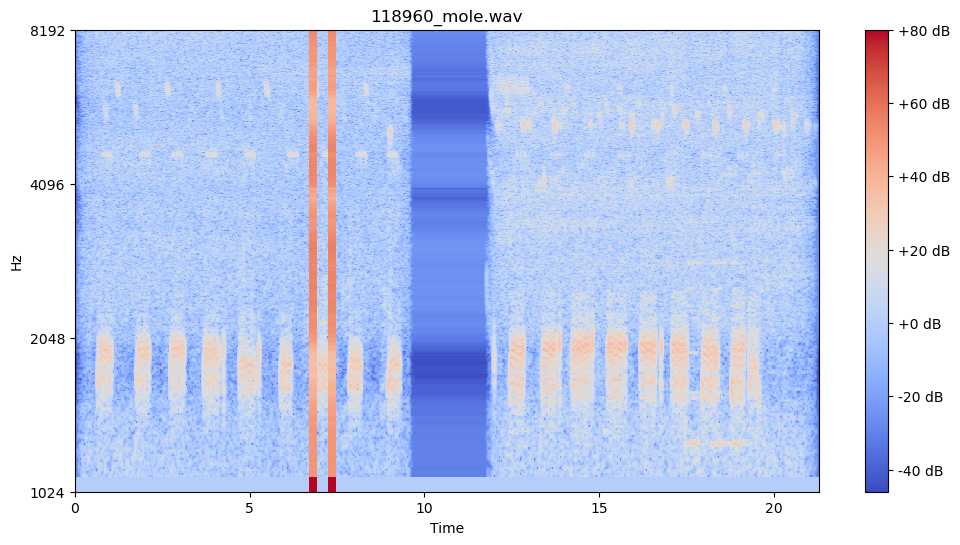

In [403]:
for x in range(D.shape[0]):
    for j in range(int(.01*D.shape[1])):
        D[x, max_t - total_left_steps -j] = max_amp
        D[x, max_t + total_right_steps +j] = max_amp
DB = librosa.amplitude_to_db(D, ref=np.max)
DBclean = np.zeros(D.shape)
for x in range(0,DB.shape[0]):
    med = np.median(DB[x, :])
    DBclean[x, :] = DB[x, :]-med
    #DBclean[x, :] = [0 if D[x,y] < med else D[x,y] for y in range(D.shape[1])]
plt.figure(figsize=(12,6))
librosa.display.specshow(DBclean, sr=sr, hop_length=128, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.ylim(1024, 1024*8)
plt.title(str(filename))
plt.show()

In [405]:
np.max(D)

96.94237